In [4]:
ls

 control.tar.xz
 data.tar.xz
 debian-binary
 gcc-11.3.0.tar.gz.1
 gcc-11.3.0.tar.gz.2
 _gpgbuilder
 Jupyter-Demo/
 management_units/
 Miniconda3-py310_24.7.1-0-Linux-x86_64.sh
 NCAR_NetCDF/
 NCAR_NetCDF_processed/
 NCAR_NetCDF_raster/
 NCAR_NetCDF_raw/
 outputs/
 output_wget_256885.txt
 overlay_check.png
 parallel_wget.sh
 profile_output.out
 projects/
 R-4.3.1.tar.gz
'~.rstudio-server'/
 rstudio-server-2024.09.0-375-amd64.deb
 sample_outputs/
 scripts/
 temp.tif


In [80]:
from netCDF4 import Dataset

# Open the NetCDF file
file_path = "/beegfs/CMIP6/stvieira/projects/2025/SWAP_ADFG/data/raw/10m_u_component_of_wind_1950.nc"
nc = Dataset(file_path, mode='r')

# Print general information about the NetCDF file
print("NetCDF File Structure:")
print(nc)

# Iterate over all variables to inspect attributes
print("\nInspecting variable attributes for nodata values:")
for var_name, variable in nc.variables.items():
    print(f"\nVariable: {var_name}")
    print("Attributes:")
    for attr_name in variable.ncattrs():
        attr_value = getattr(variable, attr_name)
        print(f"  {attr_name}: {attr_value}")

# Close the NetCDF file
nc.close()


NetCDF File Structure:
<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4 data model, file format HDF5):
    GRIB_centre: ecmf
    GRIB_centreDescription: European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre: 0
    Conventions: CF-1.7
    institution: European Centre for Medium-Range Weather Forecasts
    dimensions(sizes): valid_time(12), latitude(81), longitude(1436)
    variables(dimensions): int64 number(), int64 valid_time(valid_time), float64 latitude(latitude), float64 longitude(longitude), <class 'str'> expver(valid_time), float32 u10(valid_time, latitude, longitude)
    groups: 

Inspecting variable attributes for nodata values:

Variable: number
Attributes:
  long_name: ensemble member numerical id
  units: 1
  standard_name: realization

Variable: valid_time
Attributes:
  long_name: time
  standard_name: time
  units: seconds since 1970-01-01
  calendar: proleptic_gregorian

Variable: latitude
Attributes:
  _FillValue: nan
  units: degrees_north
  standa

In [7]:
import rasterio

src = rasterio.open ("sample_outputs/Alagnak_Wild_River_ACCESS1-3_rcp45_SM1_sample.tif")

In [60]:
import xarray as xr
import geopandas as gpd
import rioxarray
from rasterstats import zonal_stats
import pandas as pd
import os
from calculate_seasonal_means_yearly import SEASONS

# File and variable setup
netcdf_file = "/beegfs/CMIP6/stvieira/projects/2025/SWAP_ADFG/data/raw/total_precipitation_2000.nc"
netcdf_variable_name = "tp"
units = "m"
variable = "total_precipitation"
season = "DJF"
gdf = gpd.read_file("/beegfs/CMIP6/stvieira/projects/2025/SWAP_ADFG/data/resources/BiogeographicRegions_AKSWAP_ABRedited/BiogeographicRegions_AKSWAP_ABRedited.shp")

year = int(os.path.basename(netcdf_file).rsplit("_", 1)[-1].split(".")[0])
print(f"Processing file: {netcdf_file} for year {year}")

# Load NetCDF and extract the variable
ds = xr.open_dataset(netcdf_file)
data = ds[netcdf_variable_name]

# Handle nodata values
nodata_value = data.attrs.get("_FillValue", data.attrs.get("missing_value", 3.4028234663852886e+38))
data = data.where(data != nodata_value)

# Extract units from metadata and convert to mm if necessary
if "m" in data.attrs.get("units", "").lower():
    data *= 1000  # Convert meters to millimeters
    units = "mm"
elif "mm" in data.attrs.get("units", "").lower():
    units = "mm"
else:
    raise ValueError(f"Unexpected units for {variable}: {data.attrs.get('units', 'unknown')}")

# Set CRS for the NetCDF (assumes EPSG:4326 from ERA5)
data = data.rio.write_crs("EPSG:4326")

# Reproject to EPSG:3338
data_3338 = data.rio.reproject("EPSG:3338")

# Select the season's months
months = SEASONS[season]
seasonal_subset = data_3338.sel(valid_time=data_3338["valid_time.month"].isin(months))
print(seasonal_subset["valid_time"].values)  # Debug: Check included months

# Calculate seasonal min and max across all months
seasonal_min = seasonal_subset.min(dim="valid_time")
seasonal_max = seasonal_subset.max(dim="valid_time")

# Calculate seasonal aggregate (mean for temperature, sum for other variables)
seasonal_aggregate = (
    seasonal_subset.mean(dim="valid_time")
    if variable in ["2m_temperature"]
    else seasonal_subset.sum(dim="valid_time")
)

# Save the seasonal rasters to temporary GeoTIFFs
temp_raster_min = f"temp_raster_min_{variable}_{season}_{year}.tif"
temp_raster_max = f"temp_raster_max_{variable}_{season}_{year}.tif"
temp_raster_aggregate = f"temp_raster_agg_{variable}_{season}_{year}.tif"

seasonal_min.rio.to_raster(temp_raster_min)
seasonal_max.rio.to_raster(temp_raster_max)
seasonal_aggregate.rio.to_raster(temp_raster_aggregate)

# Perform zonal statistics for min, max, and aggregate rasters
stats_min = zonal_stats(
    gdf,
    temp_raster_min,
    stats=["mean", "min", "max"],
    all_touched=True,
    geojson_out=True,
    nodata=nodata_value,
)

stats_max = zonal_stats(
    gdf,
    temp_raster_max,
    stats=["mean", "min", "max"],
    all_touched=True,
    geojson_out=True,
    nodata=nodata_value,
)

stats_aggregate = zonal_stats(
    gdf,
    temp_raster_aggregate,
    stats=["mean", "min", "max"],
    all_touched=True,
    geojson_out=True,
    nodata=nodata_value,
)

# Print results (or handle as needed)
print("Included months:", seasonal_subset["valid_time"].values)
print("Seasonal min raster stats - Min:", seasonal_min.min().values, "Max:", seasonal_min.max().values)
print("Seasonal max raster stats - Min:", seasonal_max.min().values, "Max:", seasonal_max.max().values)
print("Seasonal aggregate raster stats - Min:", seasonal_aggregate.min().values, "Max:", seasonal_aggregate.max().values)



Processing file: /beegfs/CMIP6/stvieira/projects/2025/SWAP_ADFG/data/raw/total_precipitation_2000.nc for year 2000
['2000-01-01T06:00:00.000000000' '2000-02-01T06:00:00.000000000'
 '2000-12-01T06:00:00.000000000']
Included months: ['2000-01-01T06:00:00.000000000' '2000-02-01T06:00:00.000000000'
 '2000-12-01T06:00:00.000000000']
Seasonal min raster stats - Min: 0.00789111 Max: 14.076971
Seasonal max raster stats - Min: 0.09240251 Max: 19.879236
Seasonal aggregate raster stats - Min: 0.0 Max: 48.684845


('valid_time', 'latitude', 'longitude')


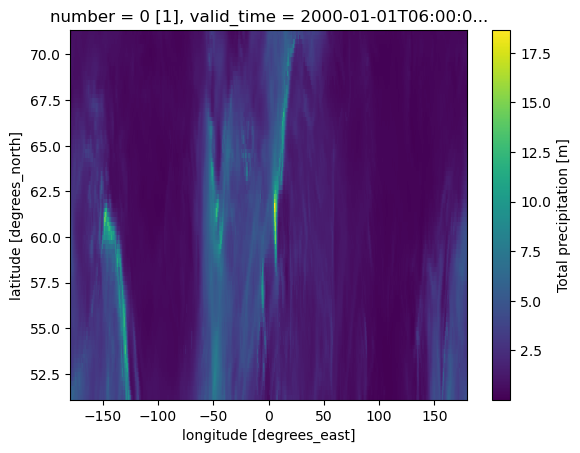

In [71]:

# ds = xr.open_dataset(netcdf_file)
# data = ds[netcdf_variable_name]
data.isel(valid_time=0).plot()
print(data.dims)

In [ ]:
print(seasonal_subset)



<xarray.DataArray 'tp' (valid_time: 3, y: 5710, x: 5965)> Size: 409MB
array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]]], dtype=float32)
Coordinates:
  * x            (x) float64 48kB -4.662e+06 -4

In [75]:
seasonal_stat = seasonal_subset.sum(dim="valid_time")  # For cumulative variables
seasonal_mean = seasonal_subset.mean(dim="valid_time")  # For averaged variables
print(data['valid_time'])

<xarray.DataArray 'valid_time' (valid_time: 12)> Size: 96B
array(['2000-01-01T06:00:00.000000000', '2000-02-01T06:00:00.000000000',
       '2000-03-01T06:00:00.000000000', '2000-04-01T06:00:00.000000000',
       '2000-05-01T06:00:00.000000000', '2000-06-01T06:00:00.000000000',
       '2000-07-01T06:00:00.000000000', '2000-08-01T06:00:00.000000000',
       '2000-09-01T06:00:00.000000000', '2000-10-01T06:00:00.000000000',
       '2000-11-01T06:00:00.000000000', '2000-12-01T06:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
    number       int64 8B 0
  * valid_time   (valid_time) datetime64[ns] 96B 2000-01-01T06:00:00 ... 2000...
    expver       (valid_time) <U4 192B '0001' '0001' '0001' ... '0001' '0001'
    spatial_ref  int64 8B 0
Attributes:
    long_name:      time
    standard_name:  time


In [76]:
print(seasonal_stat)
print(seasonal_mean)

<xarray.DataArray 'tp' (y: 5710, x: 5965)> Size: 136MB
array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)
Coordinates:
  * x            (x) float64 48kB -4.662e+06 -4.661e+06 ... 4.673e+06 4.674e+06
  * y            (y) float64 46kB 9.058e+06 9.057e+06 ... 1.224e+05 1.208e+05
    number       int64 8B 0
    spatial_ref  int64 8B 0
<xarray.DataArray 'tp' (y: 5710, x: 5965)> Size: 136MB
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]], dtype=float32)
Coordinates:
  * x            (x) float64 48kB -4.662e+06 -4.661e+06 ... 4.673e+06 4.674e+06
  * y            (y) f

In [77]:
print(data_3338)

<xarray.DataArray 'tp' (valid_time: 12, y: 5710, x: 5965)> Size: 2GB
array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
...
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, 

In [51]:
print(data_3338["valid_time"].values)


['2000-01-01T06:00:00.000000000' '2000-02-01T06:00:00.000000000'
 '2000-03-01T06:00:00.000000000' '2000-04-01T06:00:00.000000000'
 '2000-05-01T06:00:00.000000000' '2000-06-01T06:00:00.000000000'
 '2000-07-01T06:00:00.000000000' '2000-08-01T06:00:00.000000000'
 '2000-09-01T06:00:00.000000000' '2000-10-01T06:00:00.000000000'
 '2000-11-01T06:00:00.000000000' '2000-12-01T06:00:00.000000000']


In [70]:
import rasterio

# Open the raster file
src = rasterio.open(temp_raster_min)

# Read the first band of the raster as a NumPy array
band1 = src.read(1)

# Print the range of pixel values
print("\nPixel Value Range:")
print(f"Min: {band1.min()}, Max: {band1.max()}")
print(src.nodatavals)




Pixel Value Range:
Min: nan, Max: nan
(None,)


In [62]:
src.meta

{'driver': 'GTiff',
 'dtype': 'float32',
 'nodata': None,
 'width': 5965,
 'height': 5710,
 'count': 1,
 'crs': CRS.from_epsg(3338),
 'transform': Affine(1565.4934978858723, 0.0, -4662996.535763161,
        0.0, -1565.4934978858723, 9059021.788438406)}

In [63]:
array = src.read(1)

In [66]:
# Print the range of pixel values
print("\nPixel Value Range:")
print(f"Min: {band1.min()}, Max: {band1.max()}")


Pixel Value Range:


NameError: name 'band1' is not defined

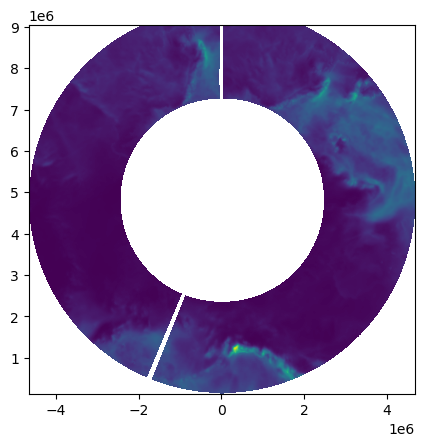

<Axes: >

In [65]:
from rasterio.plot import show  # for plotting

show(src)

In [17]:
import xarray as xr

# Path to the NetCDF file
file_path = "/beegfs/CMIP6/stvieira/projects/2025/SWAP_ADFG/data/raw/total_precipitation_2011.nc"

# Open the dataset
ds = xr.open_dataset(file_path)

# Display the structure of the dataset
print(ds)


<xarray.Dataset> Size: 6MB
Dimensions:     (valid_time: 12, latitude: 81, longitude: 1436)
Coordinates:
    number      int64 8B ...
  * valid_time  (valid_time) datetime64[ns] 96B 2011-01-01T06:00:00 ... 2011-...
  * latitude    (latitude) float64 648B 71.22 70.97 70.72 ... 51.72 51.47 51.22
  * longitude   (longitude) float64 11kB -179.1 -178.9 -178.6 ... 179.4 179.6
    expver      (valid_time) <U4 192B ...
Data variables:
    tp          (valid_time, latitude, longitude) float32 6MB ...
Attributes:
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts


In [58]:
import xarray as xr

# Path to the NetCDF file
file_path = "/beegfs/CMIP6/stvieira/projects/2025/SWAP_ADFG/data/raw/evaporation_1996.nc"

# Open the dataset
ds = xr.open_dataset(file_path)

# Display the structure of the dataset
print(ds)
print(ds["e"].attrs.get("units", "unknown"))



<xarray.Dataset> Size: 6MB
Dimensions:     (valid_time: 12, latitude: 81, longitude: 1436)
Coordinates:
    number      int64 8B ...
  * valid_time  (valid_time) datetime64[ns] 96B 1996-01-01T06:00:00 ... 1996-...
  * latitude    (latitude) float64 648B 71.22 70.97 70.72 ... 51.72 51.47 51.22
  * longitude   (longitude) float64 11kB -179.1 -178.9 -178.6 ... 179.4 179.6
    expver      (valid_time) <U4 192B ...
Data variables:
    e           (valid_time, latitude, longitude) float32 6MB ...
Attributes:
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
m of water equivalent


In [27]:
import xarray as xr

# Path to the NetCDF file
file_path = "/beegfs/CMIP6/stvieira/projects/2025/SWAP_ADFG/data/raw/2m_temperature_1963.nc"

# Open the dataset
ds = xr.open_dataset(file_path)

# Display the structure of the dataset
print(ds)


<xarray.Dataset> Size: 6MB
Dimensions:     (valid_time: 12, latitude: 81, longitude: 1436)
Coordinates:
    number      int64 8B ...
  * valid_time  (valid_time) datetime64[ns] 96B 1963-01-01 ... 1963-12-01
  * latitude    (latitude) float64 648B 71.22 70.97 70.72 ... 51.72 51.47 51.22
  * longitude   (longitude) float64 11kB -179.1 -178.9 -178.6 ... 179.4 179.6
    expver      (valid_time) <U4 192B ...
Data variables:
    t2m         (valid_time, latitude, longitude) float32 6MB ...
Attributes:
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts


In [1]:
# print(ds["t2m"].attrs)
print(ds["t2m"].attrs.get("GRIB_missingValue", None))


NameError: name 'ds' is not defined

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import glob


In [7]:
# Directory containing the CSV files
data_dir = "/beegfs/CMIP6/stvieira/projects/2025/SWAP_ADFG/data/outputs"

climate_data = {}
for file in glob.glob(f"{data_dir}/*.csv"):
    var_name = file.split("/")[-1].split("_seasonal_summaries")[0]  # Extract variable name
    print(f"Loading {var_name} from {file}")
    climate_data[var_name] = pd.read_csv(file)

Loading evaporation from /beegfs/CMIP6/stvieira/projects/2025/SWAP_ADFG/data/outputs/evaporation_seasonal_summaries.csv
Loading snowfall from /beegfs/CMIP6/stvieira/projects/2025/SWAP_ADFG/data/outputs/snowfall_seasonal_summaries.csv
Loading 2m_temperature from /beegfs/CMIP6/stvieira/projects/2025/SWAP_ADFG/data/outputs/2m_temperature_seasonal_summaries.csv
Loading 10m_v_component_of_wind from /beegfs/CMIP6/stvieira/projects/2025/SWAP_ADFG/data/outputs/10m_v_component_of_wind_seasonal_summaries.csv
Loading 10m_u_component_of_wind from /beegfs/CMIP6/stvieira/projects/2025/SWAP_ADFG/data/outputs/10m_u_component_of_wind_seasonal_summaries.csv
Loading total_precipitation from /beegfs/CMIP6/stvieira/projects/2025/SWAP_ADFG/data/outputs/total_precipitation_seasonal_summaries.csv


In [8]:
climate_data["2m_temperature"].head()


,Region,Year,Season,Mean_2m_temperature_C,Min_2m_temperature_C,Max_2m_temperature_C
0,North,1950,DJF,-24.880313,-30.448898,-19.179367
1,Central,1950,DJF,-22.027629,-30.448898,-14.033208
2,Southeast,1950,DJF,-8.374416,-19.139328,2.794586
3,West,1950,DJF,-17.090267,-27.228521,-5.196625
4,Southcentral,1950,DJF,-13.420163,-24.434250,2.252269


In [15]:
for var, df in climate_data.items():
    # Rename columns for consistency (removing units or unnecessary characters)
    df.columns = [col.strip().replace(" ", "_").lower() for col in df.columns]
for var, df in climate_data.items():
    df.columns = [
        col.replace("_m_s**-1", "_mps").replace(" ", "_").lower()
        for col in df.columns
    ]


Generating plots for 2m_temperature...


/tmp/ipykernel_2837392/3894196077.py:46: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(title="Region", loc="upper left", bbox_to_anchor=(1.05, 1))


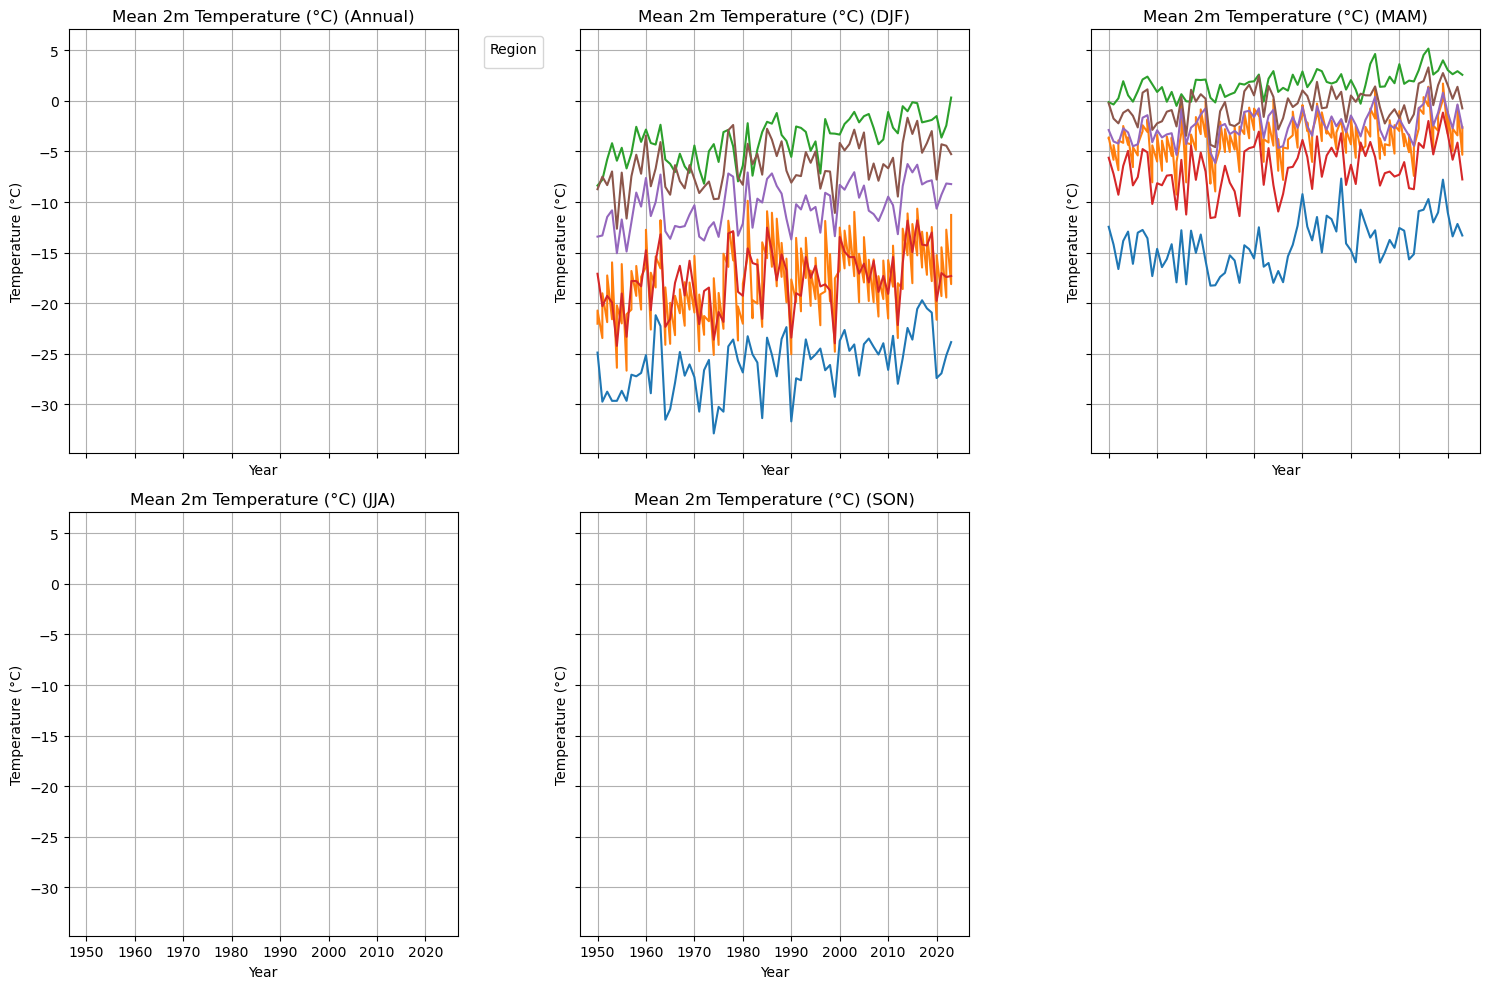

Generating plots for total_precipitation...


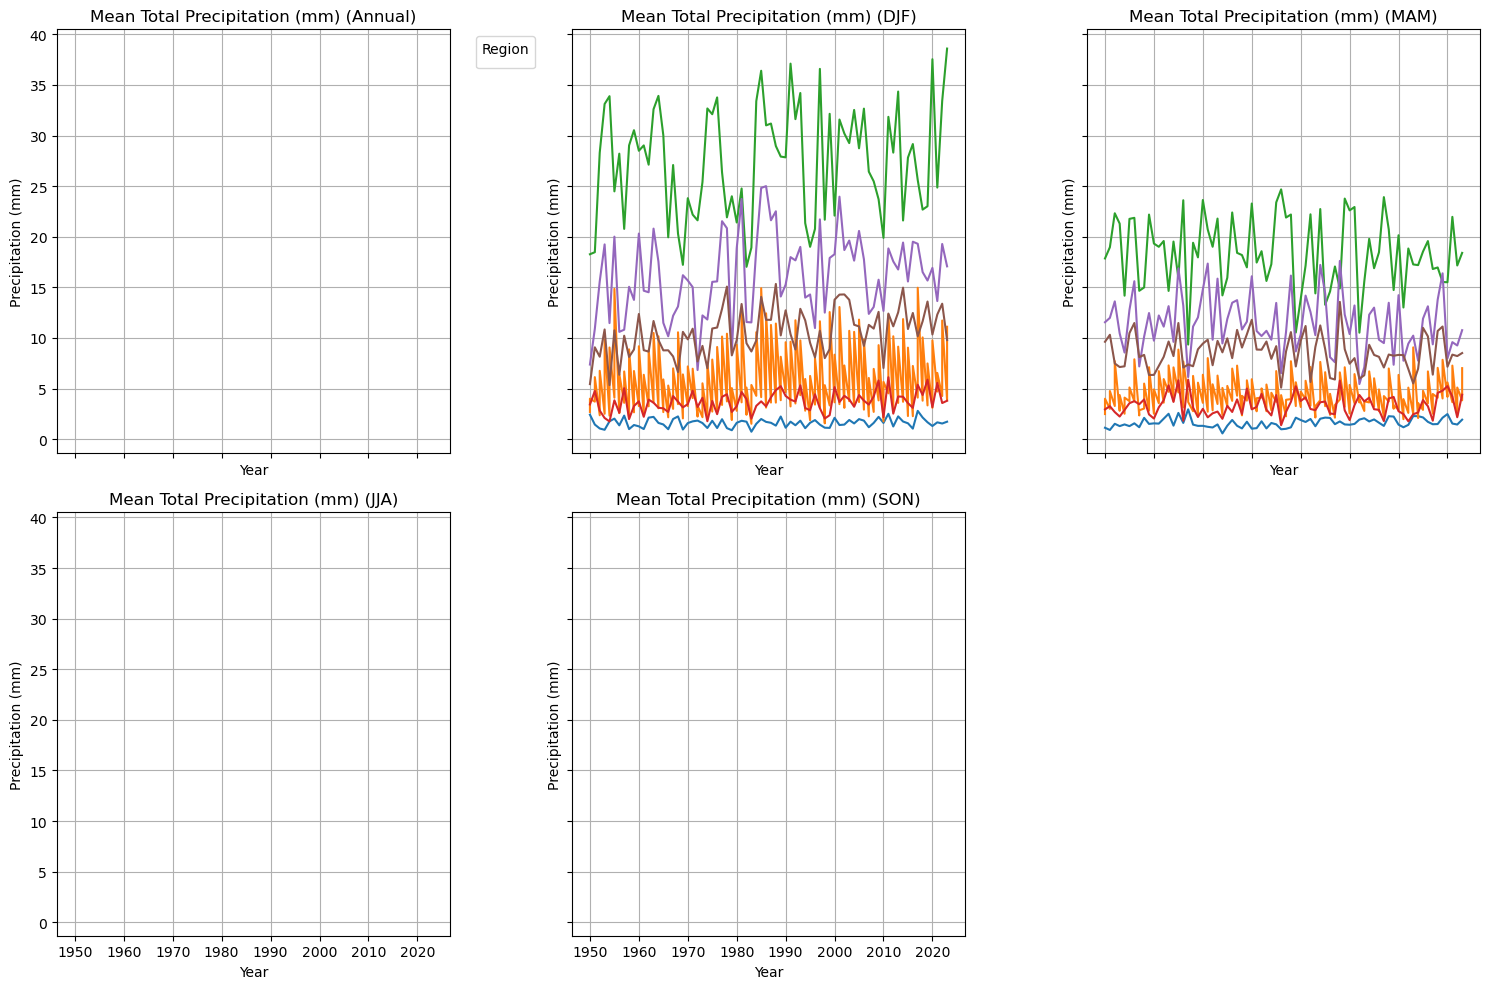

Generating plots for snowfall...


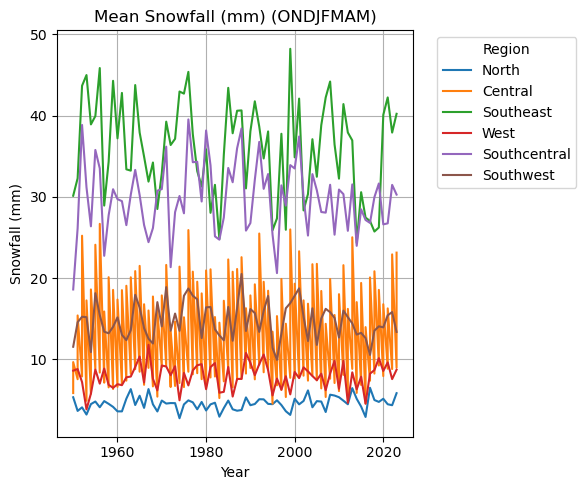

Generating plots for evaporation...


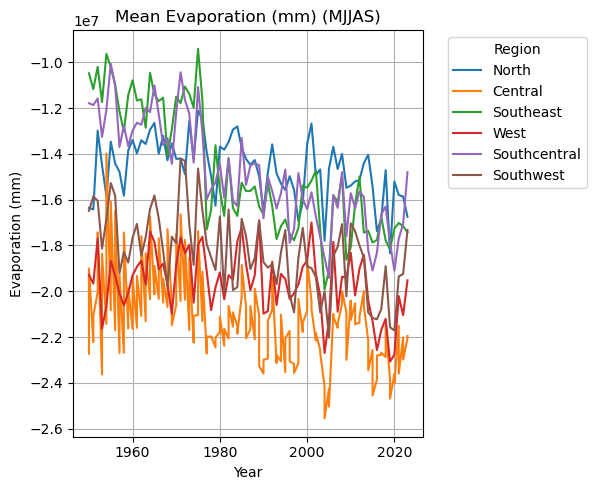

Generating plots for 10m_u_component_of_wind...


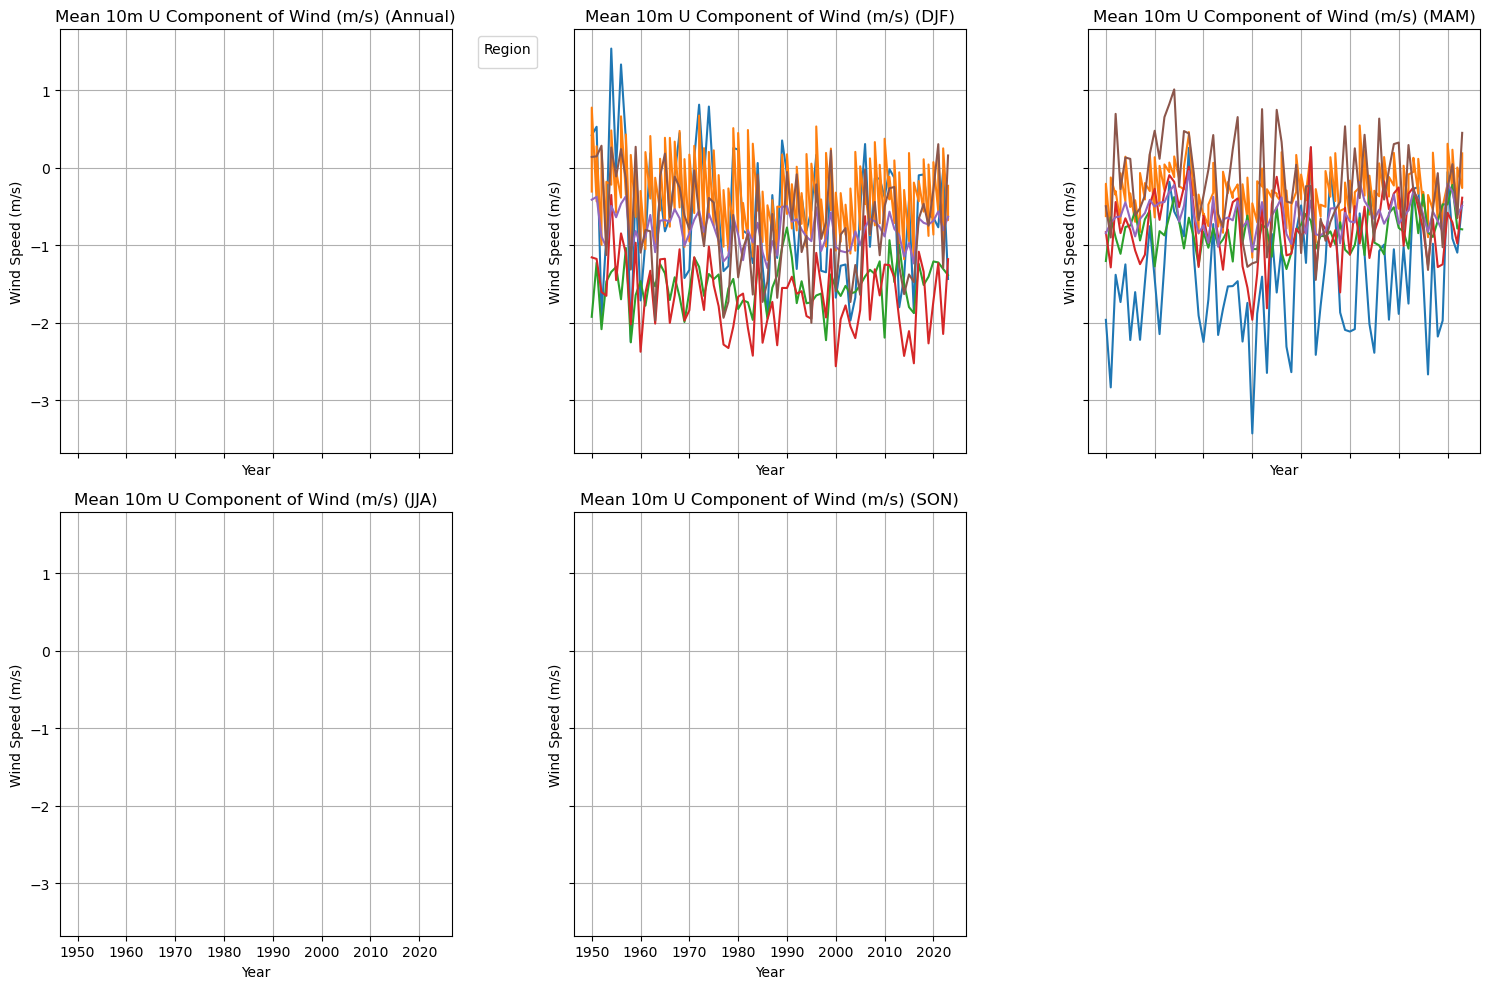

Generating plots for 10m_v_component_of_wind...


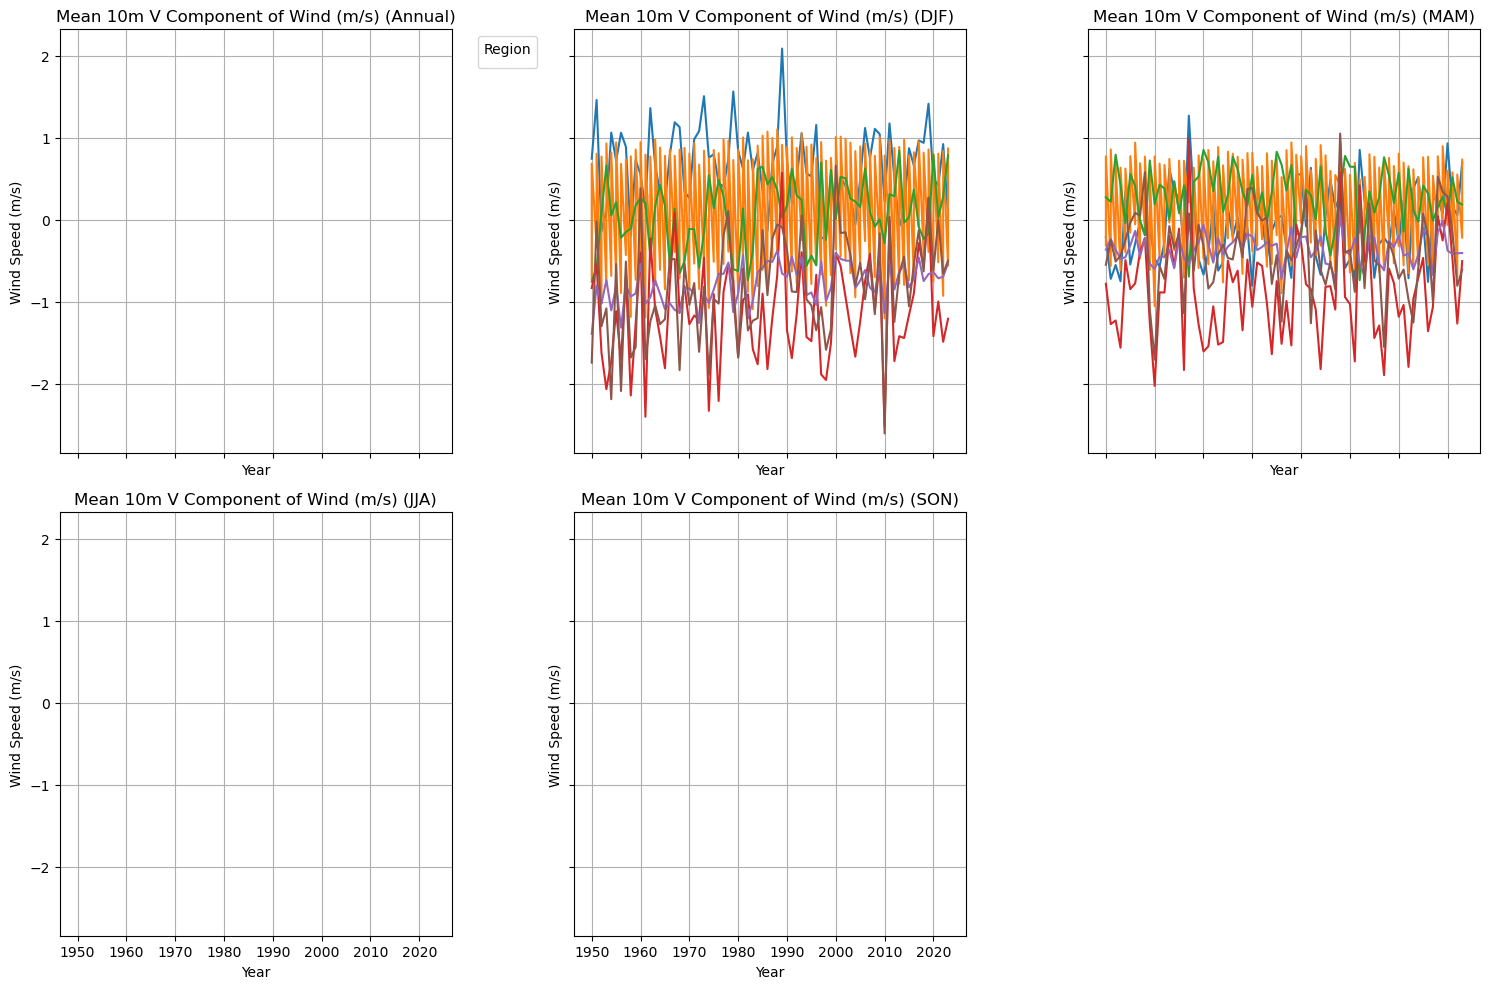

In [18]:
import matplotlib.pyplot as plt

def plot_time_series_grid(data, variable, y_col, title, ylabel, valid_seasons, regions):
    """
    Plots a grid of time series for specified variable and seasons with regions overlaid.
    
    Args:
        data (pd.DataFrame): Input data containing 'region', 'year', 'season', and y_col.
        variable (str): The climate variable being plotted (e.g., "2m_temperature").
        y_col (str): Column name for the y-axis data.
        title (str): Base title for the plot.
        ylabel (str): Label for the y-axis.
        valid_seasons (list): Seasons to include in the grid.
        regions (list): Regions to overlay on the plots.
    """
    # Create subplots with a grid layout
    n_seasons = len(valid_seasons)
    n_cols = 3  # Number of columns in the grid
    n_rows = (n_seasons + n_cols - 1) // n_cols  # Compute number of rows needed
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5 * n_rows), sharex=True, sharey=True)
    axes = axes.flatten()  # Flatten in case of a 2D grid

    for i, season in enumerate(valid_seasons):
        ax = axes[i]
        
        for region in regions:
            # Filter data for the region and season
            seasonal_data = data[
                (data["region"] == region) & 
                (data["season"] == season)
            ]
            if not seasonal_data.empty:
                ax.plot(
                    seasonal_data["year"], 
                    seasonal_data[y_col], 
                    label=region
                )
        
        ax.set_title(f"{title} ({season})")
        ax.set_xlabel("Year")
        ax.set_ylabel(ylabel)
        ax.grid(True)

    # Remove unused subplots
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])
    
    # Create a shared legend for the entire figure
    handles, labels = ax.get_legend_handles_labels()
    fig.legend(
        handles, labels, loc="lower right", title="Region", bbox_to_anchor=(0.95, 0.02), ncol=2
    )
    
    # Adjust layout to remove space between columns
    fig.tight_layout(pad=2.0, w_pad=0.1, h_pad=2.0)
    plt.show()


# Define variables, their corresponding y_col, titles, and valid seasons
variables = [
    {
        "variable": "2m_temperature",
        "y_col": "mean_2m_temperature_c",
        "title": "Mean 2m Temperature (°C)",
        "ylabel": "Temperature (°C)",
        "valid_seasons": ["Annual", "DJF", "MAM", "JJA", "SON"]
    },
    {
        "variable": "total_precipitation",
        "y_col": "mean_total_precipitation_mm",
        "title": "Mean Total Precipitation (mm)",
        "ylabel": "Precipitation (mm)",
        "valid_seasons": ["Annual", "DJF", "MAM", "JJA", "SON"]
    },
    {
        "variable": "snowfall",
        "y_col": "mean_snowfall_mm",
        "title": "Mean Snowfall (mm)",
        "ylabel": "Snowfall (mm)",
        "valid_seasons": ["ONDJFMAM"]
    },
    {
        "variable": "evaporation",
        "y_col": "mean_evaporation_mm",
        "title": "Mean Evaporation (mm)",
        "ylabel": "Evaporation (mm)",
        "valid_seasons": ["MJJAS"]
    },
    {
        "variable": "10m_u_component_of_wind",
        "y_col": "mean_10m_u_component_of_wind_mps",
        "title": "Mean 10m U Component of Wind (m/s)",
        "ylabel": "Wind Speed (m/s)",
        "valid_seasons": ["Annual", "DJF", "MAM", "JJA", "SON"]
    },
    {
        "variable": "10m_v_component_of_wind",
        "y_col": "mean_10m_v_component_of_wind_mps",
        "title": "Mean 10m V Component of Wind (m/s)",
        "ylabel": "Wind Speed (m/s)",
        "valid_seasons": ["Annual", "DJF", "MAM", "JJA", "SON"]
    }
]

# Define regions
regions = ['North', 'Central', 'Southeast', 'West', 'Southcentral', 'Southwest']

# Generate gridded plots for each variable
for var in variables:
    variable = var["variable"]
    y_col = var["y_col"]
    title = var["title"]
    ylabel = var["ylabel"]
    valid_seasons = var["valid_seasons"]

    print(f"Generating plots for {variable}...")
    plot_time_series_grid(
        climate_data[variable], 
        variable, 
        y_col, 
        title, 
        ylabel, 
        valid_seasons, 
        regions
    )



In [ ]:
output_dir = "/path/to/save/plots"

for var, df in climate_data.items():
    y_col = f"mean_{var.lower()}"
    title = f"Mean {var.replace('_', ' ').capitalize()}"
    ylabel = var.replace('_', ' ').capitalize()
    
    for region in df["region"].unique():
        plt.figure(figsize=(10, 6))
        for season in df["season"].unique():
            seasonal_data = df[(df["region"] == region) & (df["season"] == season)]
            plt.plot(seasonal_data["year"], seasonal_data[y_col], label=season)
        
        plt.title(f"{title} for {region}")
        plt.xlabel("Year")
        plt.ylabel(ylabel)
        plt.legend(title="Season")
        plt.grid(True)
        
        # Save plot
        filename = f"{output_dir}/{var}_{region}_time_series.png"
        plt.savefig(filename)
        plt.close()
